some prereading: 

[Approaching (Almost) Any Machine Learning Problem](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/)


# Step 1 - get data

In [1253]:
import datetime as dt
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing, svm
# https://stackoverflow.com/a/50970152
pd.core.common.is_list_like = pd.api.types.is_list_like
# you have to install pandas_datareader module i Anaconda Navigator:
# http://docs.anaconda.com/anaconda/navigator/tutorials/manage-packages/
from pandas_datareader.data import DataReader

In [1254]:
# Define timeframe of stocks we retreive 
end = dt.datetime.now() 
start = end - dt.timedelta(days=5*365)

In [1255]:
# Use DataReader to get Apples stock data from IEX https://iextrading.com/developer/
# df = DataReader('AAPL','iex', start, end)
df = DataReader('MU','iex', start, end)
df.head()

5y


,open,high,low,close,volume
date,,,,,
2013-09-23,17.23,17.35,16.74,17.05,30432620
2013-09-24,17.13,17.16,16.83,17.04,34725197
2013-09-25,17.06,17.33,16.94,16.97,44385905
2013-09-26,17.32,17.53,17.18,17.47,49108676
2013-09-27,17.47,17.95,17.41,17.62,45015613


In [1256]:
df.tail()

,open,high,low,close,volume
date,,,,,
2018-09-17,43.59,44.3200,43.25,43.58,28205256
2018-09-18,43.93,45.8700,43.88,45.33,36507412
2018-09-19,45.78,46.0600,44.84,45.06,29264655
2018-09-20,46.40,47.2199,45.91,46.06,75144122
2018-09-21,44.40,45.6000,43.80,44.74,97053409


In [1257]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

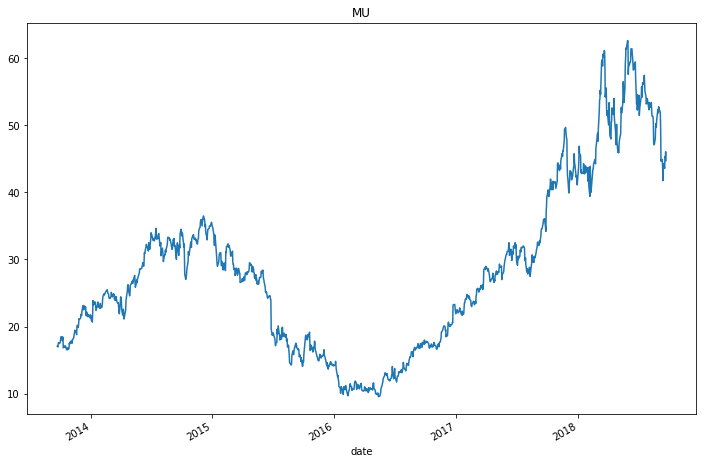

In [1258]:
df.close.plot(figsize=(12,8), title='MU')

# Step 2 - implement 2 features and visualize the price and the features in the same graph

In [1259]:
def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n, min_periods=0).min()) / (high.rolling(n, min_periods=0).max() - low.rolling(n, min_periods=0).min())) * 100
    return STOK

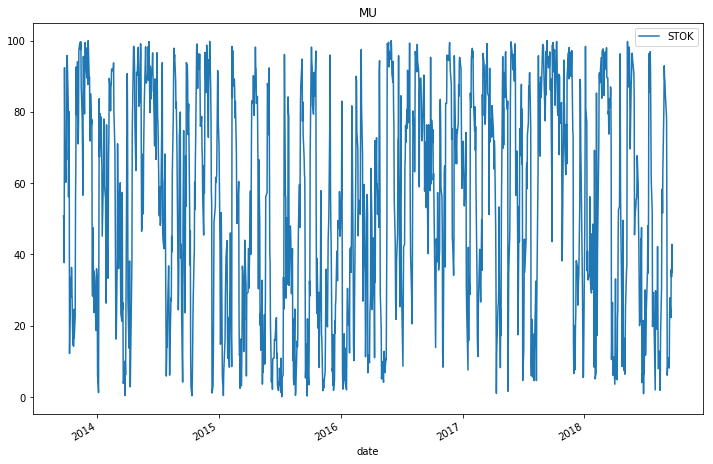

In [1260]:
# https://www.investopedia.com/articles/technical/081501.asp
#df['momentum'] = df.close - df.close.shift(4)
df['STOK'] = STOK(df['close'], df['low'], df['high'], 14)
df[['STOK']].plot(figsize=(12,8), title='MU')

# Step 3 - do a regression based on the features, forecast 1-day ahead

In [1261]:
forecast_col = 'STOK'
forecast_out = int(5)

#df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
print(df.tail(2))

print(df.columns)
print(df.index)

             open   high    low  close    volume       STOK
date                                                       
2013-09-23  17.23  17.35  16.74  17.05  30432620  50.819672
2013-09-24  17.13  17.16  16.83  17.04  34725197  49.180328


            open     high    low  close    volume       STOK
date                                                        
2018-09-20  46.4  47.2199  45.91  46.06  75144122  42.868526
2018-09-21  44.4  45.6000  43.80  44.74  97053409  34.939759
Index(['open', 'high', 'low', 'close', 'volume', 'STOK'], dtype='object')
DatetimeIndex(['2013-09-23', '2013-09-24', '2013-09-25', '2013-09-26',
               '2013-09-27', '2013-09-30', '2013-10-01', '2013-10-02',
               '2013-10-03', '2013-10-04',
               ...
               '2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
               '2018-09-14', '2018-09-17', '2018-09-18', '2018-09-19',
               '2018-09-20', '2018-09-21'],
              dtype='datetime64[ns]', name='date',

In [1262]:
x = np.array(df.drop(['STOK'], 1))
x = preprocessing.scale(x)
#print(x[1,:])
x_forecast_out = x[-forecast_out:]
x = x[:-forecast_out]
#print("Length of x_forecast_out:", len(x_forecast_out), "& length of x: ", len(x))

y = np.array(df['STOK'])
y = y[:-forecast_out]
#print('Length of y: ', len(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=None)
#print('length of x_train and x_test: ', len(x_train), len(x_test))

clf = LinearRegression()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

forecast_prediction = clf.predict(x_forecast_out)
print(forecast_prediction)

df.dropna(inplace=True)
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

Accuracy of Linear Regression:  0.10483099023241127
[59.83405044 70.66437485 50.0913286  62.16631034 72.52579698]


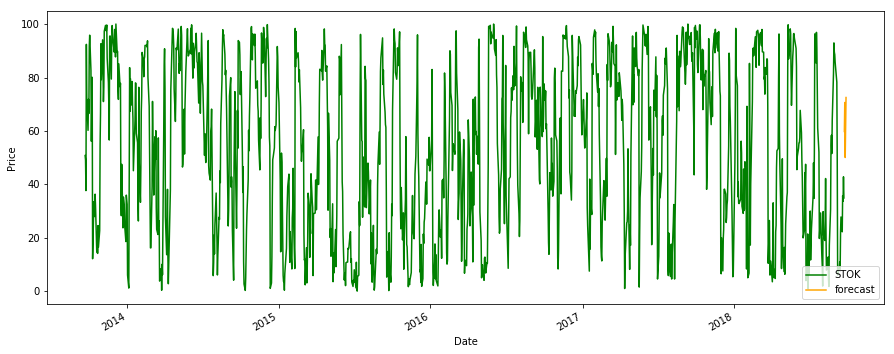

In [1263]:
df['STOK'].plot(figsize=(15,6), color='green')
df['forecast'].plot(figsize=(15,6), color='orange')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

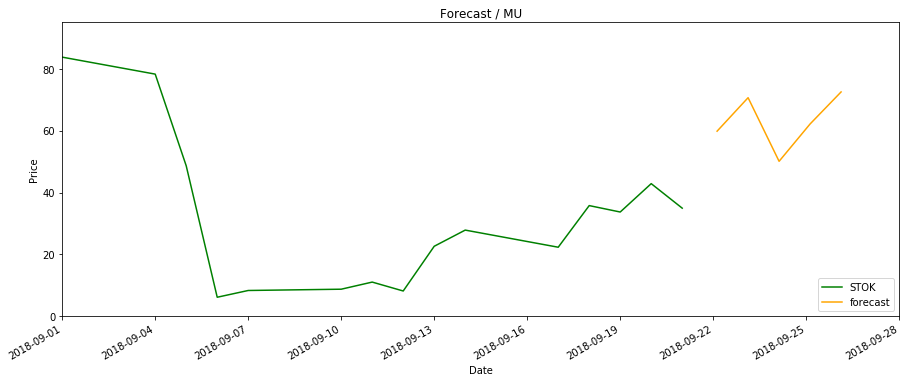

In [1266]:
df['STOK'].plot(figsize=(15,6), color='green')
df['forecast'].plot(figsize=(15,6), color='orange')
plt.xlim(xmin=datetime.date(2018,9,1), xmax=datetime.date(2018,9,28))
plt.ylim(ymin=0, ymax=95)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast / MU')
plt.show()

1 Day Forecast:


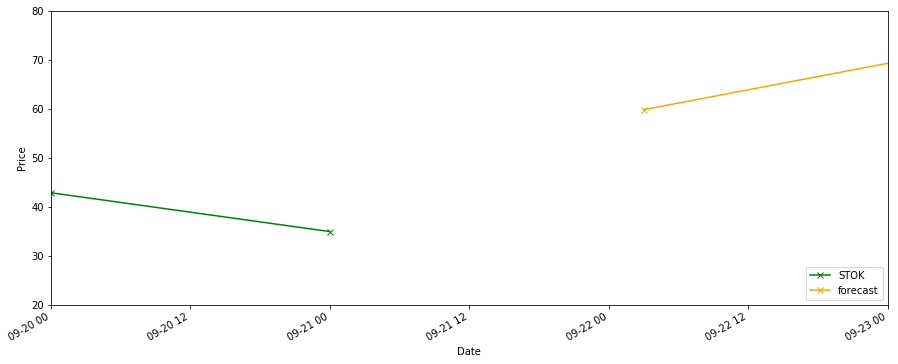

,STOK,forecast
date,,
2018-09-21 00:00:00,34.939759,NaN
2018-09-22 03:00:00,NaN,59.83405


In [1265]:
print('1 Day Forecast:')
df['STOK'].plot(figsize=(15,6), color='green', marker='x')
df['forecast'].plot(figsize=(15,6), color='orange', marker='x')
plt.xlim(xmin=(datetime.date.today() - datetime.timedelta(days=2)), xmax=(datetime.date.today() + datetime.timedelta(days=1)))
plt.ylim(ymin=20, ymax=80)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
df[['STOK','forecast']][(-forecast_out)-1:(-forecast_out)+1]

In [1245]:

# Run all cells to this point so nothing breaks.

In [1251]:
next_unix

# Step 4 - plot (as a line) the regression and expected output, make the plot zoomable

# Step 5 - add 2 more features from the “Type 2” category of features presented in the paper

# Step 6 - design a decision for when to invest and when to sell based on your regression. 
## The model can be naïve, meaning you can create a rule (if .. X .. then .. Y)